## Code for `NeuralNetwork` Class

In [2]:
%%writefile neuralnetwork.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers: list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs: int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    error_trace : list
        Mean square error (standardized) after each epoch
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples

    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        # ....
        self.n_inputs = n_inputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.n_outputs = n_outputs
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        self.total_epochs = 0
        self.error_trace = []

        # Build list of shapes for weight matrices in each layer
        # ...
        self._build_shapes()

        # Call make_weights_and_views to create all_weights and Ws
        # ...
        self.all_weights, self.Ws = self.make_weights_and_views(self.shapes)

        # Call make_weights_and_views to create all_gradients and Grads
        # ...
        self.all_gradients, self.Grads = self.make_weights_and_views(self.shapes)

    def _build_shapes(self):
        """List of Tuples containing matrix shapes given the dimension of the inputs, outputs, and number of hidden layers.

        Parameters
        ----------
        N/A

        Returns
        -------
        Void
        """
        self.shapes = []
        bias_dimension = 1
        self.n_layers = len(self.n_hidden_units_by_layers)
        if self.n_layers > 0:
            self.shapes.append((self.n_inputs + bias_dimension, self.n_hidden_units_by_layers[0]))
            loopRange = len(self.n_hidden_units_by_layers)
            for i in range(1, loopRange):
                self.shapes.append(
                    (self.n_hidden_units_by_layers[i - 1] + bias_dimension, self.n_hidden_units_by_layers[i]))
            self.shapes.append((self.n_hidden_units_by_layers[loopRange - 1] + bias_dimension, self.n_outputs))
        else:
            self.shapes.append((self.n_inputs + bias_dimension, self.n_outputs))

    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values
        #  ...
        dimension = 0
        for i in range(len(shapes)):
            dims = shapes[i]
            dimension += (dims[0] * dims[1])

        one_dim = np.random.uniform(-1, 1, size=(dimension,))
        one_dim = one_dim.astype(np.float64, copy=False)

        # Build list of views by reshaping corresponding elements
        # from vector of all weights into correct shape for each layer.
        # ...
        views = []
        offset = 0
        for j in range(len(shapes)):
            matrix_shape = shapes[j]
            slice_length = matrix_shape[0] * matrix_shape[1]
            one_dim[offset:slice_length + offset] /= np.sqrt(matrix_shape[0])
            views.append(one_dim[offset:slice_length + offset].reshape(matrix_shape[0], matrix_shape[1]))
            offset += slice_length

        return one_dim, views

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, ' + \
               f'{self.n_hidden_units_by_layers}, {self.n_outputs})'

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += f'\n Trained for {self.total_epochs} epochs.'
            s += f'\n Final standardized training error {self.error_trace[-1]:.4g}.'
        return s

    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        # ...
        self.X_means = X.mean(axis=0)
        self.X_stds = X.std(axis=0)
        self.T_means = T.mean(axis=0)
        self.T_stds = T.std(axis=0)
        self.n_epochs = n_epochs
        
        # Handle divide by zero. replace by median std across columns. Is there a better way?
        median_Xstds = np.median(self.X_stds[self.X_stds > 0])
        self.X_stds[self.X_stds == 0] = median_Xstds

        median_Tstds = np.median(self.T_stds[self.T_stds > 0])
        self.T_stds[self.T_stds == 0] = median_Tstds

        if learning_rate is None:
            learning_rate = 0.001

        # Standardize X and T
        # ...
        X = (X - self.X_means) / self.X_stds
        T = (T - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        error_convert_f = lambda err: (np.sqrt(err) * self.T_stds)[0]

        # Call the requested optimizer method to train the weights.

        if method == 'sgd':
            error_trace = optimizer.sgd(self.error_f, self.gradient_f, fargs=[X, T], n_epochs=self.n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=verbose, error_convert_f=error_convert_f, nesterov=False,
                                        callback_f=None)

        elif method == 'adam':
            error_trace = optimizer.adam(self.error_f, self.gradient_f, fargs=[X, T], n_epochs=self.n_epochs,
                                         learning_rate=learning_rate, verbose=verbose,
                                         error_convert_f=error_convert_f, callback_f=None)

        elif method == 'scg':
            error_trace = optimizer.scg(self.error_f, self.gradient_f, fargs=[X, T], n_epochs=self.n_epochs,
                                        error_convert_f=error_convert_f,
                                        verbose=verbose, callback_f=None)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(error_trace)
        self.error_trace += error_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X

        Parameters
        ----------
        X : input samples, standardized

        Returns
        -------
        Outputs of all layers as list
        """

        # Append output of each layer to list in self.Ys, then return it.
        # ...

        self.Ys = [X]
        loopRange = len(self.Ws) - 1
        for i in range(loopRange):
            W = self.Ws[i][1:, :]
            Y_temp = self.Ys[i]
            bias = self.Ws[i][:1, :]
            Y = np.tanh(Y_temp @ W + bias)
            self.Ys.append(Y)
        bias = self.Ws[loopRange][:1, :]
        W = self.Ws[loopRange][1:, :]
        Y = self.Ys[loopRange] @ W + bias
        self.Ys.append(Y)
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net and its mean squared error

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Mean square error as scalar float that is the mean
        square error over all samples
        """
        # Call _forward, calculate mean square error and return it.
        # ...
        # print("in error_f: X[0] is {0} and T[0] is {1}".format(X[0], T[0]))
        Y = self._forward(X)[-1]
        mse = np.mean((T - Y) ** 2)
        # print("in error_f: mse is {0}".format(mse))
        return mse

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # D is delta matrix to be back propagated
        D = -(T - self.Ys[-1]) / (n_samples * n_outputs)
        # print("in gradient_f: X[0] is {0} and T[0] is {1}".format(X[0], T[0]))
        # print("in gradient_f: first D calculated is \n{0}".format(str(D)))
        # Step backwards through the layers to back-propagate the error (D)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.Grads[layeri][1:, :] = self.Ys[layeri].T @ D
            # gradient of just the bias weights
            self.Grads[layeri][0:1, :] = np.sum(D, axis=0)
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                D = D @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
                # print("in gradient_f: next D is \n{0}".format(str(D)))

        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  x  number of outputs
        """

        # Standardize X
        # ...
        X = (X - self.X_means) / self.X_stds

        Y_norm = self._forward(X)[-1]
        Y = (Y_norm * self.T_stds) + self.T_means

        # Unstandardize output Y before returning it
        return Y

    def get_error_trace(self):
        """Returns list of standardized mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetwork.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  



method is sgd and rho is 0.01

sgd: Epoch 1 ObjectiveF=0.56994
sgd: Epoch 2 ObjectiveF=0.56994
sgd: Epoch 3 ObjectiveF=0.56994
sgd: Epoch 4 ObjectiveF=0.56994
sgd: Epoch 5 ObjectiveF=0.56994
sgd: Epoch 6 ObjectiveF=0.56994
sgd: Epoch 7 ObjectiveF=0.56993
sgd: Epoch 8 ObjectiveF=0.56993
sgd: Epoch 9 ObjectiveF=0.56993
sgd: Epoch 10 ObjectiveF=0.56993

method is adam and rho is 0.005

Adam: Epoch 1 ObjectiveF=0.56994
Adam: Epoch 2 ObjectiveF=0.56992
Adam: Epoch 3 ObjectiveF=0.56991
Adam: Epoch 4 ObjectiveF=0.56992
Adam: Epoch 5 ObjectiveF=0.56992
Adam: Epoch 6 ObjectiveF=0.56992
Adam: Epoch 7 ObjectiveF=0.56992
Adam: Epoch 8 ObjectiveF=0.56991
Adam: Epoch 9 ObjectiveF=0.56990
Adam: Epoch 10 ObjectiveF=0.56988

method is scg and rho is None

SCG: Epoch 1 ObjectiveF=0.56991
SCG: Epoch 2 ObjectiveF=0.56991
SCG: Epoch 3 ObjectiveF=0.56991
SCG: Epoch 4 ObjectiveF=0.56991
SCG: Epoch 5 ObjectiveF=0.56991
SCG: Epoch 6 ObjectiveF=0.56987
SCG: Epoch 7 ObjectiveF=0.56932
SCG: Epoch 8 ObjectiveF=0.

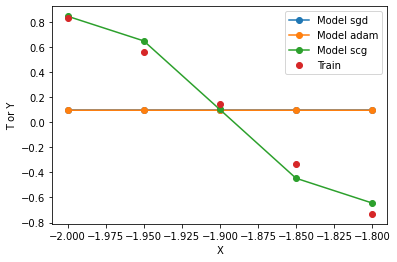

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

# Just use first 5 samples
X = X[:5, :]
T = T[:5, :]

errors = []
# n_epochs = 1000
n_epochs = 10

method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    
    print('\n=========================================')
    print(f'method is {method} and rho is {rho}')
    print('=========================================\n')

    nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
    # Set all weights here to allow comparison of your calculations
    # Must use [:] to overwrite values in all_weights.
    # Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
    nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
    
    nnet.train(X, T, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

sgd: Epoch 5000 ObjectiveF=0.53616
sgd: Epoch 10000 ObjectiveF=0.53594
sgd: Epoch 15000 ObjectiveF=0.53581
sgd: Epoch 20000 ObjectiveF=0.53550
sgd: Epoch 25000 ObjectiveF=0.50392
sgd: Epoch 30000 ObjectiveF=0.41202
sgd: Epoch 35000 ObjectiveF=0.38675
sgd: Epoch 40000 ObjectiveF=0.38626
sgd: Epoch 45000 ObjectiveF=0.38608
sgd: Epoch 50000 ObjectiveF=0.38598
Adam: Epoch 5000 ObjectiveF=0.05222
Adam: Epoch 10000 ObjectiveF=0.01871
Adam: Epoch 15000 ObjectiveF=0.01283
Adam: Epoch 20000 ObjectiveF=0.01230
Adam: Epoch 25000 ObjectiveF=0.01053
Adam: Epoch 30000 ObjectiveF=0.00997
Adam: Epoch 35000 ObjectiveF=0.00951
Adam: Epoch 40000 ObjectiveF=0.00954
Adam: Epoch 45000 ObjectiveF=0.02858
Adam: Epoch 50000 ObjectiveF=0.00850
SCG: Epoch 5000 ObjectiveF=0.02444
SCG: Epoch 10000 ObjectiveF=0.00245
SCG: Epoch 15000 ObjectiveF=0.00159
SCG: Epoch 20000 ObjectiveF=0.00141
SCG: Epoch 25000 ObjectiveF=0.00126
SCG: Epoch 30000 ObjectiveF=0.00115
SCG: Epoch 35000 ObjectiveF=0.00111
SCG: Epoch 40000 Obje

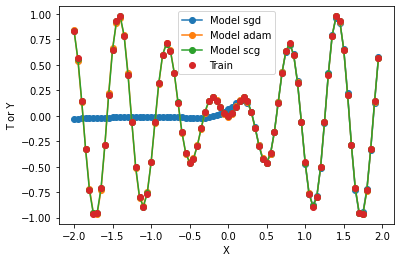

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

errors = []
n_epochs = 1000
method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(X.shape[1], [10, 10], 1)
    nnet.train(X, T, 50000, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

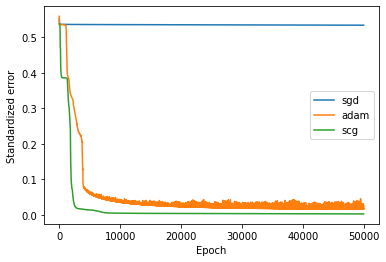

In [5]:
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Your results will not be the same, but your code should complete and make plots somewhat similar to these.

## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

In [20]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    n_train = round(n_samples * train_fraction)
    
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]
    return Xtrain, Ttrain, Xtest, Ttest
    
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [10]:
# Assuming you have assigned `X` and `T` correctly.
df = pd.read_csv("boston.csv")
X = df.iloc[:, :13].to_numpy()
T = df.iloc[:, 13:].to_numpy()
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)
print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)

(405, 13) (405, 1) (101, 13) (101, 1)


Write and run code using your `NeuralNetwork` class to model the Boston housing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method.  Show your results using print statements that include the method, network structure, number of epochs, learning rate, and RMSE on training data and RMSE on testing data.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

In [21]:
method = ['sgd','adam','scg']
rhos = [0.001, 0.0005, None]
network_architectures = [[10, 10, 10],
                        [5, 10, 20, 10, 5],
                        []]
number_epochs = [100, 1000, 10000]

for method in method:
    for rho in rhos:
        for architecture in network_architectures:
            for epoch in number_epochs:
                if rho is not None and method != "scg":
                    print("Method: {0}, Rho: {1}, Architecture: {2}, Num Epochs: {3}".format(method, rho, architecture, epoch))
                    nnet = nn.NeuralNetwork(Xtrain.shape[1], architecture, Ttrain.shape[1])
                    nnet.train(Xtrain, Ttrain, epoch, method=method, learning_rate=rho, verbose=False)
                    Ytrain = nnet.use(Xtrain)
                    Ytest = nnet.use(Xtest)
                    train_rmse = rmse(Ttrain, Ytrain)
                    test_rmse = rmse(Ttest, Ytest)
                    print("Train RMSE: {0}".format(train_rmse))
                    print("Test RMSE: {0}".format(test_rmse))
                    print("\n\n")
                elif rho is None and method == "scg":
                    print("Method: {0}, Rho: {1}, Architecture: {2}, Num Epochs: {3}".format(method, rho, architecture, epoch))
                    nnet = nn.NeuralNetwork(Xtrain.shape[1], architecture, Ttrain.shape[1])
                    nnet.train(Xtrain, Ttrain, epoch, method=method, learning_rate=rho, verbose=False)
                    Ytrain = nnet.use(Xtrain)
                    Ytest = nnet.use(Xtest)
                    train_rmse = rmse(Ttrain, Ytrain)
                    test_rmse = rmse(Ttest, Ytest)
                    print("Train RMSE: {0}".format(train_rmse))
                    print("Test RMSE: {0}".format(test_rmse))
                    print("\n\n")


Method: sgd, Rho: 0.001, Architecture: [10, 10, 10], Num Epochs: 100
Train RMSE: 8.38528234396525
Test RMSE: 9.676150090322993



Method: sgd, Rho: 0.001, Architecture: [10, 10, 10], Num Epochs: 1000
Train RMSE: 4.635480796055343
Test RMSE: 4.6320114983955225



Method: sgd, Rho: 0.001, Architecture: [10, 10, 10], Num Epochs: 10000
Train RMSE: 2.521430368263147
Test RMSE: 2.526991197333589



Method: sgd, Rho: 0.001, Architecture: [5, 10, 20, 10, 5], Num Epochs: 100
Train RMSE: 8.885105600043698
Test RMSE: 10.220594231365421



Method: sgd, Rho: 0.001, Architecture: [5, 10, 20, 10, 5], Num Epochs: 1000
Train RMSE: 5.328127230413354
Test RMSE: 5.469276817662801



Method: sgd, Rho: 0.001, Architecture: [5, 10, 20, 10, 5], Num Epochs: 10000
Train RMSE: 2.491283305602382
Test RMSE: 2.960619400486473



Method: sgd, Rho: 0.001, Architecture: [], Num Epochs: 100
Train RMSE: 5.347084321875127
Test RMSE: 5.679571496585467



Method: sgd, Rho: 0.001, Architecture: [], Num Epochs: 1000
Train RM

In [23]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


The best solution that my matrix of runs above produced was the following:
   * Method: adam, Rho: 0.001, Architecture: [5, 10, 20, 10, 5], Num Epochs: 1000
   * Train RMSE: 2.159154115697235
   * Test RMSE: 2.4251565123620953
   
There were however quite a few combinations of hyperparameters the resulted in solutions very close to the one above. In some cases, other hyperparameters resulted in a lower Train RMSE but did not generalize as well to the test data. In other cases the Train RMSE was significantly better than the above solution but always resulted in a terrible Test RMSE. It is likely that the models are overfitting the train data which indicates their poor performance on the test data. We could mitigate this issue if we introduced a validation data set. We could check our RMSE each epoch against this validation data and ensure that it's RMSE is decreasing from epoch to epoch. The moment it starts to increase, we could kill training because it might indicate that we are overfitting.

The most consistent models in the above output were the linear models. I say consistent because they never displayed any of the overfitting characteristics that the more complex models did. The linear models, while consistent, did tend to underperform (stochasticity aside) compared to the non-linear models.

The Test RMSE that the best model did produce was not ideal but decent. Given that the average of MEDV was ~$22,000, our model is predicting values no more than ~10% plus-or-minus the average median value of owner-occupied homes. Ideally, we would want our RMSE to be as close to zero as possible. However, given the data that we have, we may not be able to achieve an optimal RMSE with either a linear regression model or a neural network. Perhaps our lack of data and moderate probability to overfit the data indicates that we might look at different types of models that perform better than the two tested here with less data and have better safeguards to avoid overfitting.


In [12]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Lipe-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    import neuralnetwork as nn

    n_inputs = 3
    n_hiddens = [10, 20]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = [10, 500, 6, 3]
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.log(X + 0.1)
    n_outputs = T.shape[1]
 

<Figure size 432x288 with 0 Axes>

In [26]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("energydata_complete.csv")
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [29]:
# lets remove the "date" column now that we have the features that are most desirable
df = df.drop(labels="date", axis=1)

In [30]:
# Verify no NaN
df.isnull().values.any()

False

In [31]:
# Verify column types
df.dtypes

Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
date_year        int64
date_month       int64
date_hour        int64
dtype: object

In [25]:
# Convert to floats to be safe and get some summary stats
df = df.astype(np.float64)
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,date_year,date_month,date_hour
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.0,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,2016.0,3.101647,11.502002
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,0.0,1.339200,6.921953
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,2016.0,1.000000,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,2016.0,2.000000,6.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,2016.0,3.000000,12.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,2016.0,4.000000,17.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,2016.0,5.000000,23.000000


In [12]:
# Sample train and test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)

In [13]:
# Collect targets and remove from inputs
T_train = df_train[["Appliances", "lights"]]
T_test = df_test[["Appliances", "lights"]]
df_train = df_train.drop(labels=["Appliances", "lights"], axis=1)
df_test = df_test.drop(labels=["Appliances", "lights"], axis=1)

In [18]:
# Train and predict
Xtrain = df_train.to_numpy()
Ttrain = T_train.to_numpy()
Xtest = df_test.to_numpy()
Ttest = T_test.to_numpy()
print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)

(15788, 29) (15788, 2) (3947, 29) (3947, 2)


In [23]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10, 10], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, 10000, method="adam", learning_rate=0.001, verbose=False)
Ytrain = nnet.use(Xtrain)
Ytest = nnet.use(Xtest)

# Compute error for both of our predicted targets
train_rmse = rmse(Ttrain[:, 0:1], Ytrain[:, 0:1])
test_rmse = rmse(Ttest[:, 0:1], Ytest[:, 0:1])
print("Appliances Train RMSE: {0}".format(train_rmse))
print("Appliances Test RMSE: {0}".format(test_rmse))
print("")
train_rmse = rmse(Ttrain[:, 1:], Ytrain[:, 1:])
test_rmse = rmse(Ttest[:, 1:], Ytest[:, 1:])
print("lights Train RMSE: {0}".format(train_rmse))
print("lights Test RMSE: {0}".format(test_rmse))

Appliances Train RMSE: 73.96791976342878
Appliances Test RMSE: 94.76871227572138

lights Train RMSE: 5.375479211630016
lights Test RMSE: 6.009678560512261


In [24]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10, 10], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, 10000, method="scg", learning_rate=None, verbose=False)
Ytrain = nnet.use(Xtrain)
Ytest = nnet.use(Xtest)

# Compute error for both of our predicted targets
train_rmse = rmse(Ttrain[:, 0:1], Ytrain[:, 0:1])
test_rmse = rmse(Ttest[:, 0:1], Ytest[:, 0:1])
print("Appliances Train RMSE: {0}".format(train_rmse))
print("Appliances Test RMSE: {0}".format(test_rmse))
print("")
train_rmse = rmse(Ttrain[:, 1:], Ytrain[:, 1:])
test_rmse = rmse(Ttest[:, 1:], Ytest[:, 1:])
print("lights Train RMSE: {0}".format(train_rmse))
print("lights Test RMSE: {0}".format(test_rmse))

Appliances Train RMSE: 76.71396275338631
Appliances Test RMSE: 94.66325254127308

lights Train RMSE: 5.2021379955902445
lights Test RMSE: 5.928869689228643


I ran out of time to test further configurations. But it seems that our targets have a reasonably high variance. This might indicate why our RMSE values are very high considering the range of values our targets can take. Given enough time, the model might be able to be fine tuned to get these errors significantly lower with respect to their targets.